## Dependencies

In [36]:
from BNReasoner import BNReasoner
import pandas as pd
import numpy as np
from copy import deepcopy
import time


## Utils

In [35]:
def fail_on_float(actual: float, expected: float, eps: float=10-3):
    assert abs(actual - expected) <= eps

## Test implementation

### Test | `Network Pruning`

Before pruning...


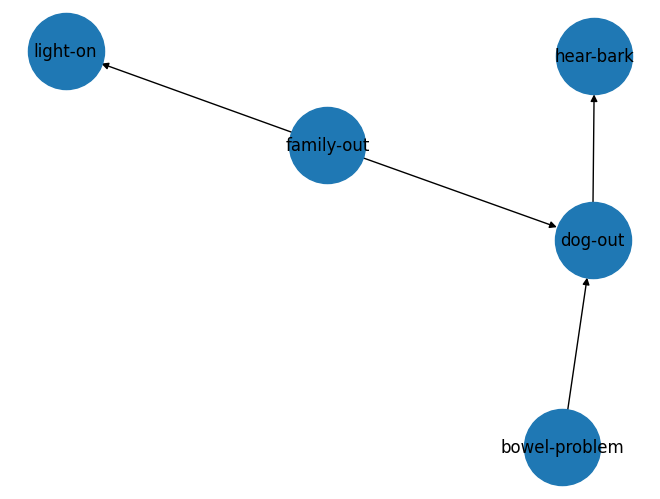

After pruning...


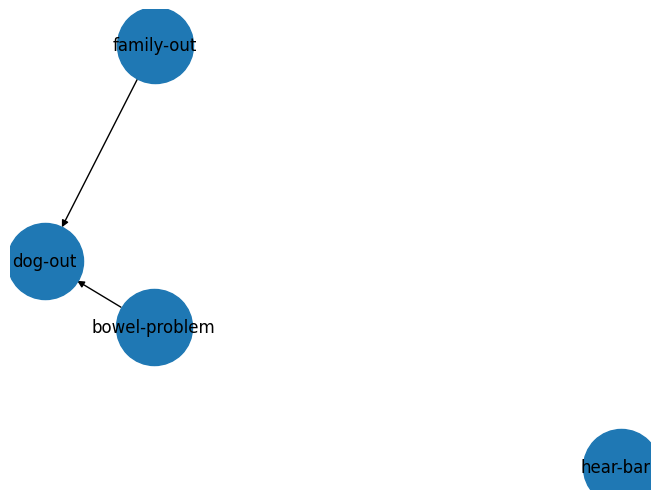

In [24]:
# Init
dog_problem = BNReasoner("testing/dog_problem.BIFXML")

print("Before pruning...")
dog_problem.draw()

# Prune
dog_problem_clone = deepcopy(dog_problem)
dog_problem_clone.prune(Q = {"bowel-problem": None, "hear-bark": None}, e = {"dog-out": None, })

print("After pruning...")
dog_problem_clone.draw()

### Test | `D separation`

In [25]:
dog_problem = BNReasoner("testing/dog_problem.BIFXML")

assert dog_problem.d_separated(X = {"dog-out": None}, Y = {"bowel-problem": None}, Z = {})
assert dog_problem.d_separated(X = {"dog-out": None}, Y = {"hear-bark": None}, Z = {"dog-out": None, }) is False

### Test | `Maxing out variables`

In [26]:
"""
: BN course 4 -> pag. 11
:return:
"""
initial = pd.DataFrame(columns=["B", "C", "D", "f1"], data=np.array([
    [True, True, True, 0.95],
    [True, True, False, 0.05],
    [True, False, True, 0.90],
    [True, False, False, 0.10],
    [False, True, True, 0.80],
    [False, True, False, 0.20],
    [False, False, True, 0.00],
    [False, False, False, 1.00],
]))

expected = pd.DataFrame(columns=["B", "C", "max_D=1.0 > f1"], data=np.array([
    [True, True, 0.95],
    [True, False, 0.9],
    [False, True, 0.8],
    [False, False, 1],
]))

actual = BNReasoner("testing/dog_problem.BIFXML").maxing_out("D", initial)
assert actual.equals(expected)

### Test | `Summing out variables`

In [27]:
"""
: BN course 4 -> pag. 11
"""
initial = pd.DataFrame(columns=["B", "C", "D", "f1"], data=np.array([
    [True, True, True, 0.95],
    [True, True, False, 0.05],
    [True, False, True, 0.90],
    [True, False, False, 0.10],
    [False, True, True, 0.80],
    [False, True, False, 0.20],
    [False, False, True, 0.00],
    [False, False, False, 1.00],
]))

expected = pd.DataFrame(columns=["B", "C", "sum_D > f1"], data=np.array([
    [True, True, 1.0],
    [True, False, 1.0],
    [False, True, 1.0],
    [False, False, 1.0],
]))

actual = BNReasoner.marginalization("D", initial)
assert actual.equals(expected)

### Test | `Factor multiplication`

In [28]:
"""
: BN course 3 -> pag. 10
"""
first = pd.DataFrame(columns=["B", "C", "D", "f1"], data=np.array([
    [True, True, True, 0.95],
    [True, True, False, 0.05],
    [True, False, True, 0.90],
    [True, False, False, 0.10],
    [False, True, True, 0.80],
    [False, True, False, 0.20],
    [False, False, True, 0.00],
    [False, False, False, 1.00],
]))

second = pd.DataFrame(columns=["D", "E", "f2"], data=np.array([
    [True, True, 0.448],
    [True, False, 0.192],
    [False, True, 0.112],
    [False, False, 0.248],
]))

expected_first_2_rows = pd.DataFrame(columns=["B", "C", "D", "E", "f1 * f2"], data=np.array([
    [True, True, True, True, 0.95 * 0.448],
    [True, True, True, False, 0.95 * 0.192],
]))

actual = BNReasoner.factor_multiplication(first, second)
actual_first_2_rows = actual.iloc[0:2]
assert actual_first_2_rows.equals(expected_first_2_rows)

### Test | `Marginal Distribution`

In [29]:
dog_problem = BNReasoner("testing/dog_problem.BIFXML")

dog_problem.marginal_distribution(Q={"dog-out": True, "bowel-problem": True}, e={})

,bowel-problem,dog-out,sum_family-out > p * p
0,True,True,0.7227
1,True,False,1.2573
2,False,True,0.0011
3,False,False,0.0189


### Test | `Most Probable Explanation`

In [30]:
"""
: BN course 4 -> pag. 19
: Note: There are multiple possible instantiation that yield the same trivial factor
"""
problem = BNReasoner("testing/lecture_example2.BIFXML")

actual_value, actual_instantiation = problem.compute_mpe(e={"J": True, "O": False})
expected_value, expected_instantiation = 0.2304, {'I': True, 'Y': True, 'X': True}

fail_on_float(actual_value, expected_value)
assert actual_instantiation == expected_instantiation

### Test | `Maximum A Posteriori`

In [31]:
"""
: BN course 4 -> pag. 20
: Note: There are multiple possible instantiation that yield the same trivial factor
"""
problem = BNReasoner("testing/lecture_example2.BIFXML")

expected_value, expected_instantiation = 0.25, {'I': True, 'J': True}
actual_value, actual_instantiation = problem.compute_map(Q={'I': None, 'J': None}, e={"O": False})

fail_on_float(actual_value, expected_value)
assert actual_instantiation == expected_instantiation

## Performance evaluation

In [32]:
import matplotlib.pyplot as plt

def get_time(function, **kwargs):
    start_time = time.time()
    function(**kwargs)
    return time.time() - start_time

files = ["testing/dog_problem.BIFXML", "testing/lecture_example.BIFXML", "testing/lecture_example2.BIFXML"]

#### How does the number of variables in the evidence influence the MPE execution?

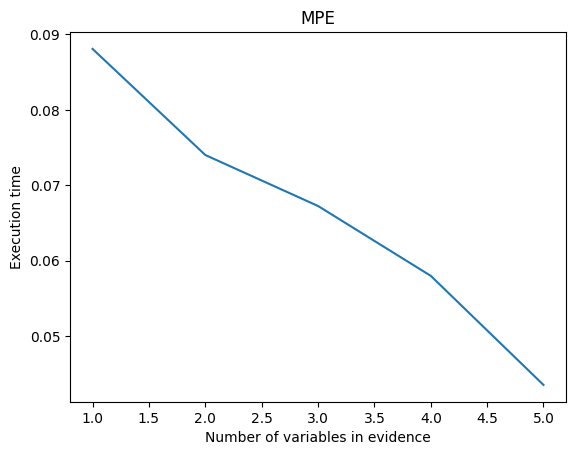

In [37]:
import matplotlib.pyplot as plt

problem.bn.get_all_variables()

e = {}
time_data = []
labels = []

for variable in problem.bn.get_all_variables():
    e.update({variable : True})
    time_data.append(get_time(problem.compute_mpe, e=e))
    labels.append(len(e.keys()))

plt.plot(labels, time_data)
plt.xlabel("Number of variables in evidence")
plt.ylabel("Execution time")
plt.title("MPE")
plt.show()    

#### How does the number of variables in Q influence the MAP execution?

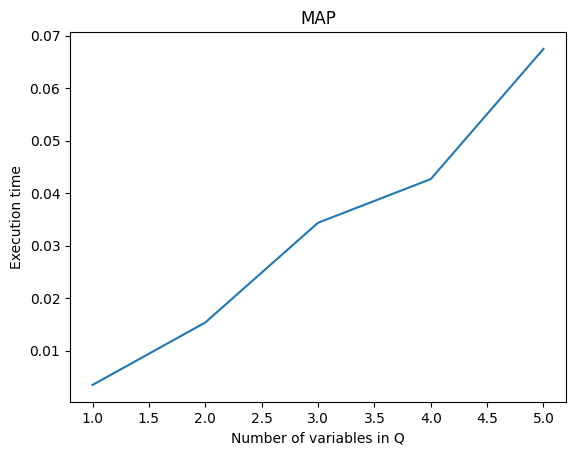

In [35]:
import matplotlib.pyplot as plt
import random

problem.bn.get_all_variables()

Q = {}
time_data = []
labels = []

for variable in problem.bn.get_all_variables():
    Q.update({variable : None})
    time_data.append(get_time(problem.compute_map, Q=Q, e={}))
    labels.append(len(Q.keys()))

plt.plot(labels, time_data)
plt.xlabel("Number of variables in Q")
plt.ylabel("Execution time")
plt.title("MAP")
plt.show()    

## Simulated Real life example

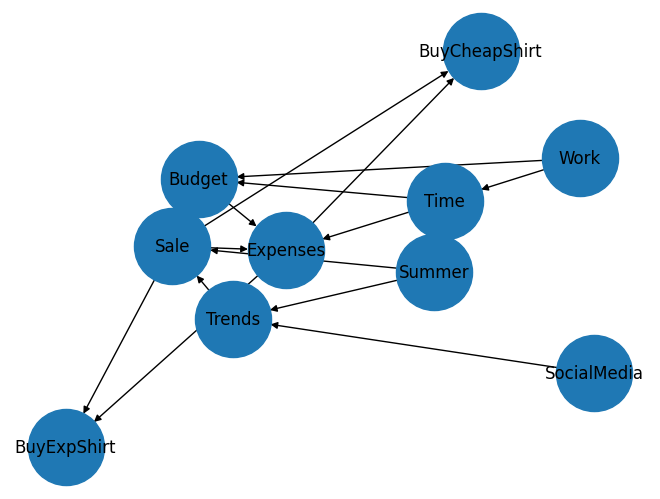

In [41]:
simulated_real_life = BNReasoner("testing/simulated_real_life.BIFXML")
simulated_real_life.draw()